In [0]:
# much help from https://github.com/nicolasfauchereau/Auckland_Cycling
# with a nice viewer option
# https://nbviewer.jupyter.org/github/nicolasfauchereau/Auckland_Cycling/blob/master/notebooks/Auckland_cycling_and_weather.ipynb
# and of course fbprophet 
# https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html
!pip install prophet

  Created wheel for prophet: filename=prophet-0.1.1-cp36-none-any.whl size=12170 sha256=656266883a767d63967f09ac38fea7eec217c8021e40f6a55421c174eabf9499
  Stored in directory: /root/.cache/pip/wheels/77/3e/f3/1c536bf1f871f818686e7fbf31cab18d52787a72dea8640756
Successfully built prophet


In [0]:
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive 
import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns
from scipy.stats import skew

In [0]:
drive.mount('/content/drive')
plt.style.use('seaborn-colorblind')
#plt.style.available

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# load the data and create a timeseries for Prophet
# https://gis.cdc.gov/grasp/fluview/fluportaldashboard.html
data_path = '/content/drive/My Drive/Project/FluViewPhase2Data/ILINet.csv'
flu_raw = pd.read_csv(data_path, skiprows=1)
flu_raw['YearWeek'] = \
    flu_raw['YEAR'].astype(str) + '-' + flu_raw['WEEK'].astype(str) + '-0'
flu_raw['ds'] = pd.to_datetime(flu_raw['YearWeek'], format='%Y-%W-%w')
flu = pd.DataFrame(flu_raw[['ds', '% WEIGHTED ILI']], copy=True)
flu.columns = ['ds', 'y']


In [0]:
# eliminate everything before 10/13/2002! These years have no data for 
flu[flu['y']==0]['ds'].max()
flu = flu[flu['ds'] > flu[flu['y']==0]['ds'].max()]
flu

,ds,y
261,2002-10-13,1.22262
262,2002-10-20,1.33344
263,2002-10-27,1.31929
264,2002-11-03,1.49484
265,2002-11-10,1.47195
...,...,...
1166,2020-02-16,6.69249
1167,2020-02-23,6.01244
1168,2020-03-01,5.43193
1169,2020-03-08,5.10164


In [0]:
model = Prophet()
model = model.fit(flu)
future = model.make_future_dataframe(periods=104)
forecast = model.predict(future)
forecast

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2002-10-13,1.470968,-0.038424,2.226423,1.470968,1.470968,-0.339035,-0.339035,-0.339035,-0.339035,-0.339035,-0.339035,0.0,0.0,0.0,1.131933
1,2002-10-20,1.471885,0.182665,2.327066,1.471885,1.471885,-0.206603,-0.206603,-0.206603,-0.206603,-0.206603,-0.206603,0.0,0.0,0.0,1.265282
2,2002-10-27,1.472802,0.261004,2.524959,1.472802,1.472802,-0.158476,-0.158476,-0.158476,-0.158476,-0.158476,-0.158476,0.0,0.0,0.0,1.314326
3,2002-11-03,1.473718,0.228331,2.548930,1.473718,1.473718,-0.125964,-0.125964,-0.125964,-0.125964,-0.125964,-0.125964,0.0,0.0,0.0,1.347754
4,2002-11-10,1.474635,0.359353,2.595157,1.474635,1.474635,-0.034067,-0.034067,-0.034067,-0.034067,-0.034067,-0.034067,0.0,0.0,0.0,1.440568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1009,2020-06-23,2.654811,0.568774,2.859702,2.654329,2.655458,-0.917244,-0.917244,-0.917244,-0.917244,-0.917244,-0.917244,0.0,0.0,0.0,1.737567
1010,2020-06-24,2.655299,0.660594,2.761809,2.654791,2.655973,-0.921818,-0.921818,-0.921818,-0.921818,-0.921818,-0.921818,0.0,0.0,0.0,1.733481
1011,2020-06-25,2.655788,0.623970,2.791729,2.655259,2.656482,-0.926155,-0.926155,-0.926155,-0.926155,-0.926155,-0.926155,0.0,0.0,0.0,1.729632
1012,2020-06-26,2.656276,0.603645,2.793468,2.655740,2.656990,-0.930387,-0.930387,-0.930387,-0.930387,-0.930387,-0.930387,0.0,0.0,0.0,1.725889


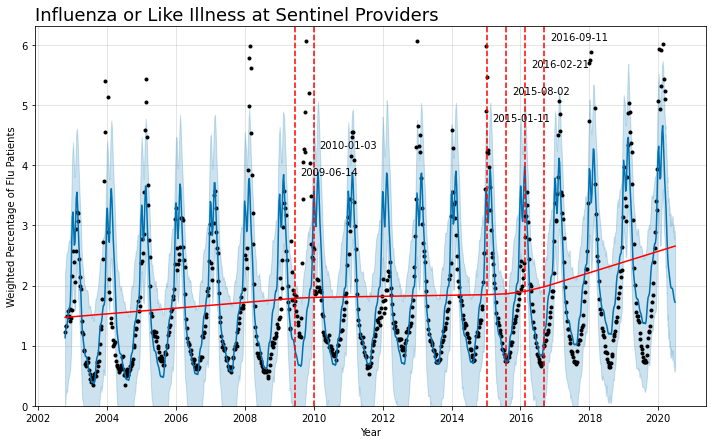

In [0]:
def plot_forecast(model, forecast, title):
    fig = model.plot(forecast)
    ax = fig.gca()
    ax.set_ylabel('Weighted Percentage of Flu Patients')
    ax.set_xlabel('Year')
    ax.set_title(title,
                loc = 'left',
                fontsize = 18)
    a = add_changepoints_to_plot(ax, model, forecast)

    upper_ylim = np.max([forecast['yhat_upper'].max(),
                         forecast['trend_upper'].max()]) * 1.1
    plt.ylim((0,upper_ylim))

    cps = len(a)
    offset = upper_ylim / cps / 4

    if (cps > 1):
        for i in range(1,cps):
            date_value = a[i].get_data()[0][0]
            xValue = date_value + datetime.timedelta(days=60)
            yValue = upper_ylim / 2 / cps * i + offset + upper_ylim / 2 
            plt.annotate(str(date_value.date()), xy=(xValue, yValue))
    fig.align_labels()
    plt.show()

plot_forecast(model, forecast,
              'Influenza or Like Illness at Sentinel Providers')

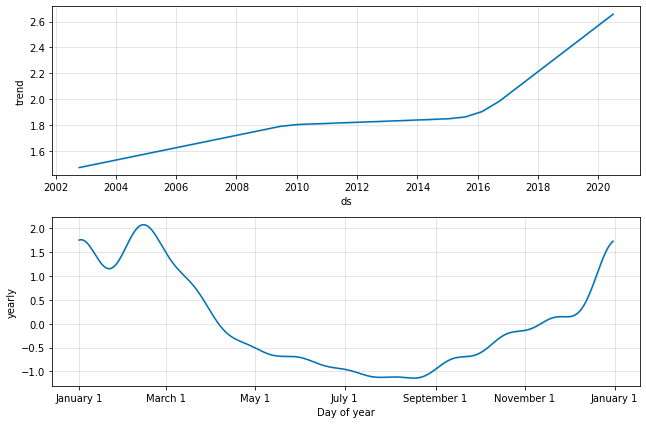

In [0]:
model.plot_components(forecast)
plt.show()

https://www.cdc.gov/flu/about/season/flu-season.htm
Flu season typically starts in October and ends in May!



In [0]:
def is_flu_season(ds):
    date = pd.to_datetime(ds)
    return (date.month >= 10 or date.month <= 5)

flu['on_season'] = flu['ds'].apply(is_flu_season)
flu['off_season'] = ~flu['ds'].apply(is_flu_season)
flu.head()

,ds,y,on_season,off_season
261,2002-10-13,1.22262,True,False
262,2002-10-20,1.33344,True,False
263,2002-10-27,1.31929,True,False
264,2002-11-03,1.49484,True,False
265,2002-11-10,1.47195,True,False


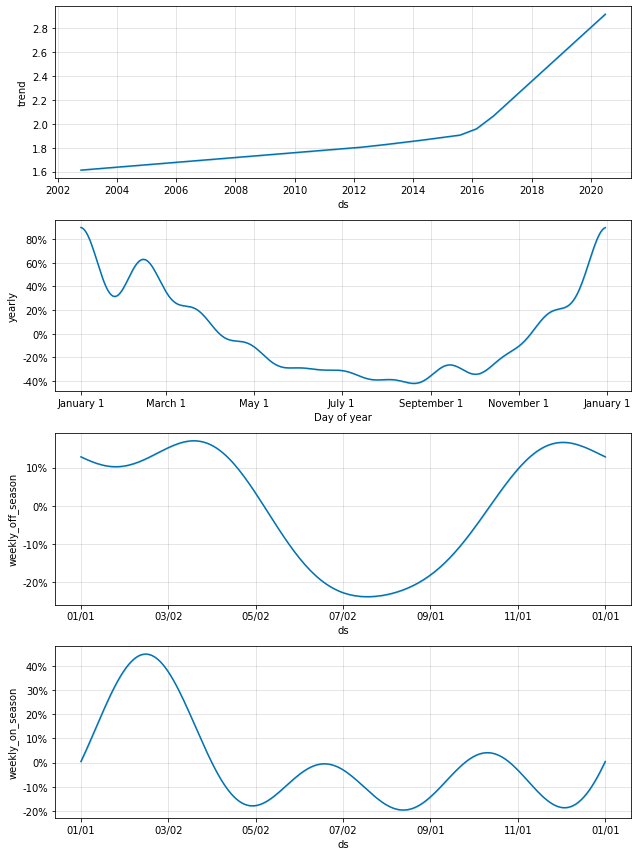

In [0]:
model = Prophet(weekly_seasonality=False, daily_seasonality=False,
                seasonality_mode='multiplicative')
model.add_seasonality(name='weekly_on_season', period=365, fourier_order=3,
                      condition_name='on_season')
model.add_seasonality(name='weekly_off_season', period=365, fourier_order=3,
                      condition_name='off_season')

future['on_season'] = future['ds'].apply(is_flu_season)
future['off_season'] = ~future['ds'].apply(is_flu_season)

forecast = model.fit(flu).predict(future)
fig = model.plot_components(forecast)
plt.show()

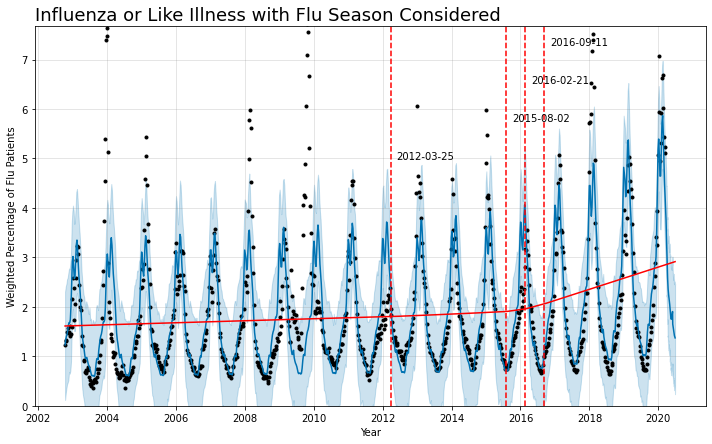

In [0]:
plot_forecast(model, forecast,
              'Influenza or Like Illness with Flu Season Considered')

In [0]:
anti_vax = pd.read_csv('/content/drive/My Drive/Project/anti_vax_by_week.csv',
                       parse_dates=['timestamp'])
pro_vax = pd.read_csv('/content/drive/My Drive/Project/pro_vax_by_week.csv',
                       parse_dates=['timestamp'])

In [0]:
print(anti_vax['timestamp'].min(), anti_vax['timestamp'].max())
print(pro_vax['timestamp'].min(), pro_vax['timestamp'].max())

2014-01-05 00:00:00 2019-04-07 00:00:00
2014-01-05 00:00:00 2019-03-31 00:00:00


In [0]:
print(flu['ds'].min(), flu['ds'].max())

2002-10-13 00:00:00 2020-03-15 00:00:00


In [0]:
flu_small = flu[flu['ds'] >= pro_vax['timestamp'].min()]
flu_small = flu_small[flu_small['ds'] <= pro_vax['timestamp'].max()]

# this will get edited so get rid of the slice
flu_small = pd.DataFrame(flu_small, copy=True)
flu_small.describe()

,y
count,274.000000
mean,2.063245
std,1.395210
min,0.639127
25%,1.077455
50%,1.537720
75%,2.626520
max,7.521330


In [0]:
flu_train = pd.DataFrame(flu_small[:222].reset_index(), copy=True)
flu_test = pd.DataFrame(flu_small[222:].reset_index(), copy=True)
flu_train = flu_train.drop('index', axis=1)
flu_test = flu_test.drop('index', axis=1)
flu_train

,ds,y,on_season,off_season
0,2014-01-05,4.59053,True,False
1,2014-01-12,4.28195,True,False
2,2014-01-19,3.56288,True,False
3,2014-01-26,3.36378,True,False
4,2014-02-02,3.39659,True,False
...,...,...,...,...
217,2018-02-25,4.95881,True,False
218,2018-03-04,3.68612,True,False
219,2018-03-11,3.18626,True,False
220,2018-03-18,2.76894,True,False


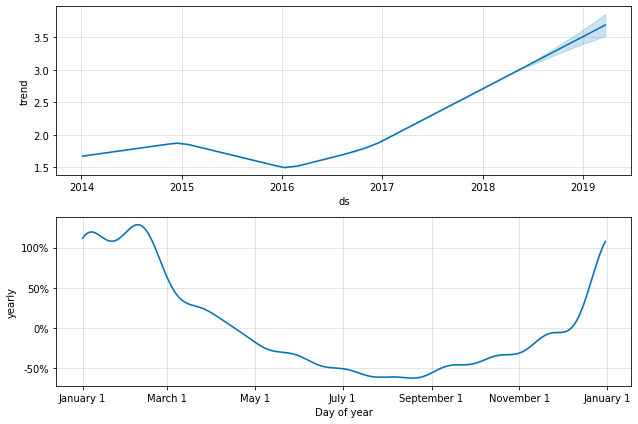

In [0]:
model = Prophet(weekly_seasonality=False, daily_seasonality=False,
                seasonality_mode='multiplicative')

model = model.fit(flu_train)
future = model.make_future_dataframe(periods=len(flu_test), freq='W')

future['on_season'] = future['ds'].apply(is_flu_season)
future['off_season'] = ~future['ds'].apply(is_flu_season)

forecast = model.predict(future)
fig = model.plot_components(forecast)
plt.show()

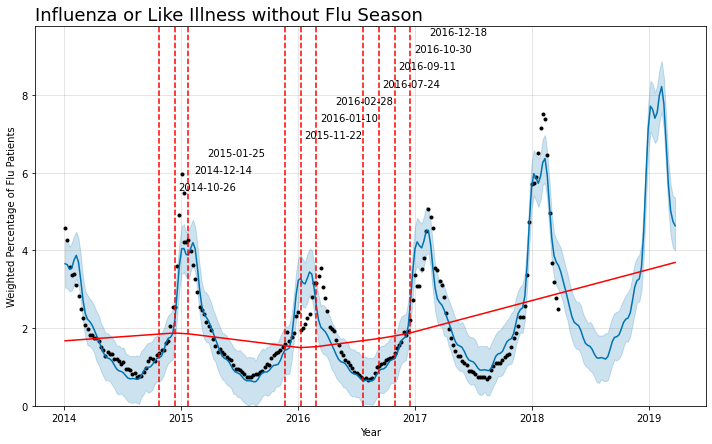

In [0]:
plot_forecast(model, forecast,
              'Influenza or Like Illness without Flu Season')

In [0]:
MSE = mean_squared_error(flu_test['y'], forecast[len(flu_train):]['yhat'])
print('Mean Squared Error: ', MSE)
MAE = mean_absolute_error(flu_test['y'], forecast[len(flu_train):]['yhat'])
print ('Mean Absolute Error:', MAE)

Mean Squared Error:  2.943889299179837
Mean Absolute Error: 1.305606075581261


In [0]:
flu_train_regressors = flu_train.copy()
flu_train_regressors['pro_posts'] = pro_vax[:len(flu_train)]['i_pro_vax']
flu_train_regressors['anti_posts'] = anti_vax[:len(flu_train)]['i_anti_vax']
flu_train_regressors['pro_sent_neg'] = pro_vax[:len(flu_train)]['sentiment_neg']
flu_train_regressors['pro_sent_neu'] = pro_vax[:len(flu_train)]['sentiment_neu']
flu_train_regressors['pro_sent_pos'] = pro_vax[:len(flu_train)]['sentiment_pos']
flu_train_regressors['anti_sent_neg'] = \
    anti_vax[:len(flu_train)]['sentiment_neg']
flu_train_regressors['anti_sent_neu'] = \
    anti_vax[:len(flu_train)]['sentiment_neu']
flu_train_regressors['anti_sent_pos'] = \
    anti_vax[:len(flu_train)]['sentiment_pos']
flu_train_regressors.describe()

,y,pro_posts,anti_posts,pro_sent_neg,pro_sent_neu,pro_sent_pos,anti_sent_neg,anti_sent_neu,anti_sent_pos
count,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000
mean,2.058738,114.779279,128.112613,0.039257,0.711703,0.161724,0.060195,0.544174,0.075635
std,1.411193,55.392233,71.519455,0.011677,0.048772,0.026126,0.017193,0.106276,0.026974
min,0.663501,33.000000,3.000000,0.013182,0.553459,0.105284,0.000000,0.000000,0.000000
25%,1.077455,69.000000,69.250000,0.032168,0.683929,0.144104,0.049527,0.502324,0.060942
50%,1.526840,99.000000,123.000000,0.038146,0.720488,0.161490,0.058844,0.566239,0.073685
75%,2.544188,155.000000,173.750000,0.046363,0.747820,0.175526,0.069551,0.607296,0.088811
max,7.521330,244.000000,309.000000,0.080529,0.819121,0.287036,0.121556,0.739602,0.222690


In [0]:
future['pro_posts'] = pro_vax['i_pro_vax']
future['anti_posts'] = anti_vax['i_anti_vax']
future['pro_sent_neg'] = pro_vax['sentiment_neg']
future['pro_sent_neu'] = pro_vax['sentiment_neu']
future['pro_sent_pos'] = pro_vax['sentiment_pos']
future['anti_sent_neg'] = anti_vax['sentiment_neg']
future['anti_sent_neu'] = anti_vax['sentiment_neu']
future['anti_sent_pos'] = anti_vax['sentiment_pos']
future.describe()
future.tail()

,ds,on_season,off_season,pro_posts,anti_posts,pro_sent_neg,pro_sent_neu,pro_sent_pos,anti_sent_neg,anti_sent_neu,anti_sent_pos
269,2019-02-24,True,False,565,877,0.055315,0.740736,0.163234,0.061578,0.614445,0.074261
270,2019-03-03,True,False,688,966,0.048129,0.741219,0.159782,0.056768,0.591647,0.076231
271,2019-03-10,True,False,808,1125,0.053330,0.739658,0.169875,0.058332,0.594191,0.072805
272,2019-03-17,True,False,897,1181,0.051946,0.717310,0.162749,0.066228,0.598520,0.074447
273,2019-03-24,True,False,820,1477,0.052695,0.737463,0.157407,0.071941,0.646460,0.069017


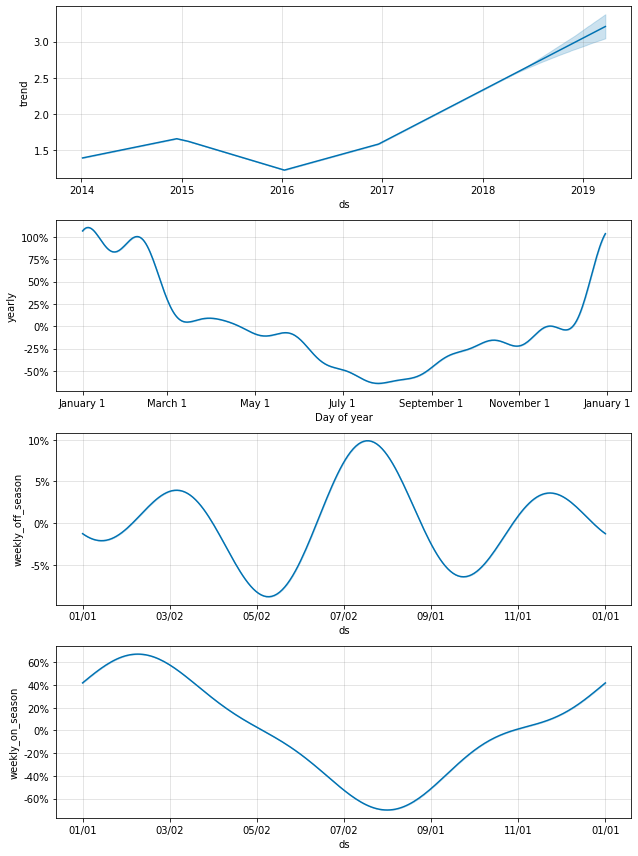

In [0]:
model = Prophet(weekly_seasonality=False, daily_seasonality=False,
                seasonality_mode='multiplicative')
model.add_seasonality(name='weekly_on_season', period=365, fourier_order=3,
                      condition_name='on_season')
model.add_seasonality(name='weekly_off_season', period=365, fourier_order=3,
                      condition_name='off_season')
model = model.fit(flu_train_regressors)

future['on_season'] = future['ds'].apply(is_flu_season)
future['off_season'] = ~future['ds'].apply(is_flu_season)

forecast = model.predict(future)
fig = model.plot_components(forecast)
plt.show()

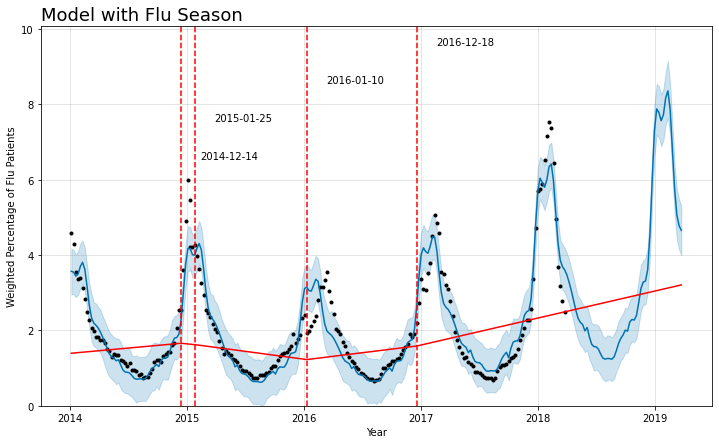

In [0]:
plot_forecast(model, forecast, 'Model with Flu Season')

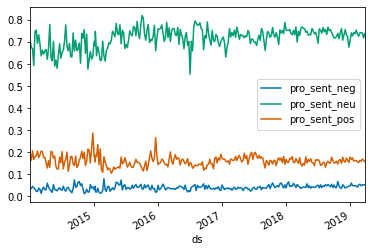

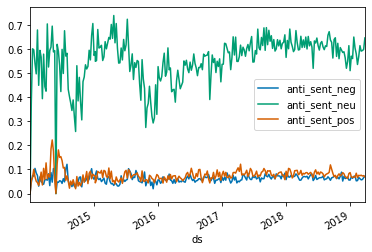

In [0]:
future.plot('ds', ['pro_sent_neg', 'pro_sent_neu', 'pro_sent_pos'])
plt.show()
future.plot('ds', ['anti_sent_neg', 'anti_sent_neu', 'anti_sent_pos'])
plt.show()

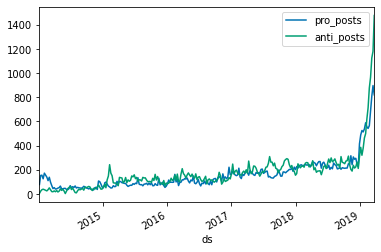

In [0]:
fig = future.plot('ds', ['pro_posts', 'anti_posts'])
plt.show()


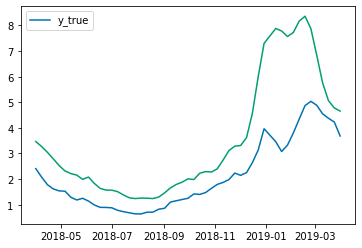

In [0]:
fig = plt.figure()
ax = plt.plot('ds', 'y_true', data=flu_test.rename({'y':'y_true'}, axis=1))
ax = plt.plot(flu_test['ds'], forecast[len(flu_train):]['yhat'])
plt.legend()
plt.show()

In [0]:
MSE_s = mean_squared_error(flu_test['y'], forecast[len(flu_train):]['yhat'])
print("Mean Square Error, no regressors:", MSE)
print("Mean Square Error, with regressors and flu season:", MSE_s)
MAE_s = mean_absolute_error(flu_test['y'], forecast[len(flu_train):]['yhat'])
print ('Mean Absolute Error:', MAE)
print("Mean Absolute Error, with flu season:", MAE_s)

Mean Square Error, no regressors: 2.943889299179837
Mean Square Error, with regressors and flu season: 3.199358331052075
Mean Absolute Error: 1.305606075581261
Mean Absolute Error, with flu season: 1.3643046937173828


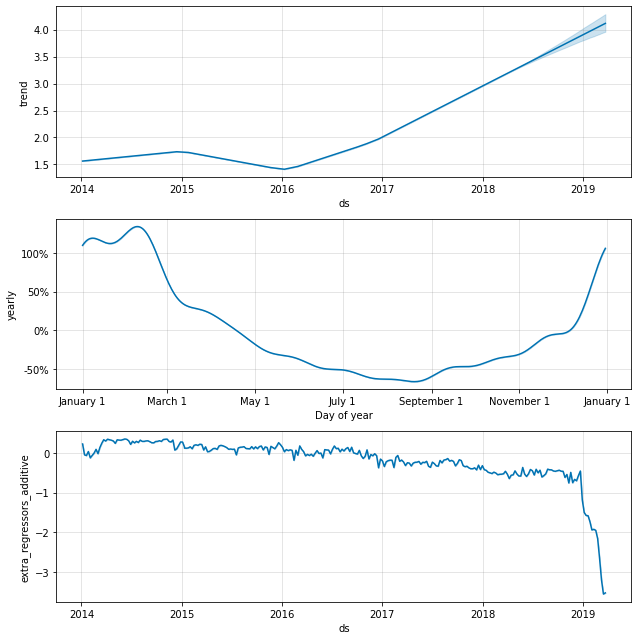

In [0]:
model = Prophet(weekly_seasonality=False, daily_seasonality=False,
                seasonality_mode='multiplicative')
model.add_regressor(name='pro_posts', mode="additive", standardize=True)
model.add_regressor(name='anti_posts', mode='additive', standardize=True)
#model.add_regressor(name='pro_sent_neg', mode='multiplicative')
#model.add_regressor(name='pro_sent_neu', mode='multiplicative')
#model.add_regressor(name='pro_sent_pos', mode='multiplicative')
#model.add_regressor(name='anti_sent_neg', mode='multiplicative')
#model.add_regressor(name='anti_sent_neu', mode='multiplicative')
#model.add_regressor(name='anti_sent_pos', mode='multiplicative')
model = model.fit(flu_train_regressors)

future['on_season'] = future['ds'].apply(is_flu_season)
future['off_season'] = ~future['ds'].apply(is_flu_season)

forecast = model.predict(future)
fig = model.plot_components(forecast)
plt.show()

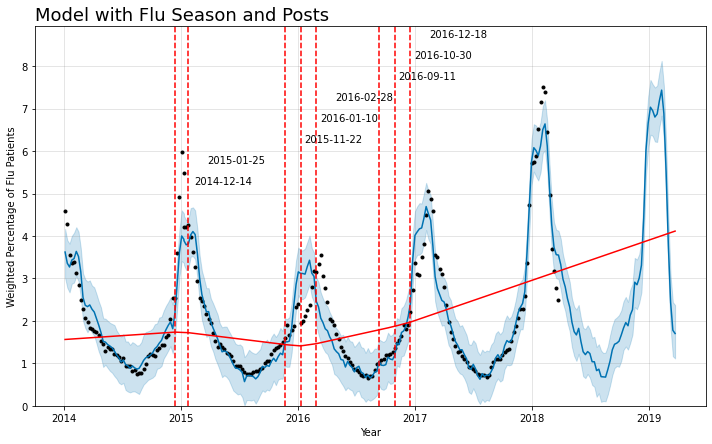

In [0]:
plot_forecast(model, forecast, 'Model with Flu Season and Posts')

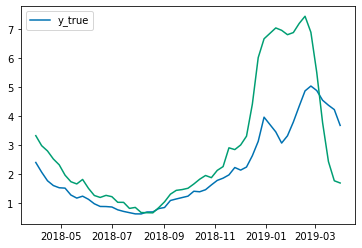

In [0]:
fig = plt.figure()
ax = plt.plot('ds', 'y_true', data=flu_test.rename({'y':'y_true'}, axis=1))
ax = plt.plot(flu_test['ds'], forecast[len(flu_train):]['yhat'])
plt.legend()
plt.show()

In [0]:
MSE_r = mean_squared_error(flu_test['y'], forecast[len(flu_train):]['yhat'])
print("Mean Square Error, no regressors:", MSE)
print("Mean Square Error, with flu season:", MSE_s)
print("Mean Square Error, with post counts and flu season:", MSE_r)
MAE_r = mean_absolute_error(flu_test['y'], forecast[len(flu_train):]['yhat'])
print ('Mean Absolute Error:', MAE)
print("Mean Absolute Error, with flu season:", MAE_s)
print("Mean Absolute Error, with post counts and flu season:", MAE_r)


Mean Square Error, no regressors: 2.943889299179837
Mean Square Error, with flu season: 3.199358331052075
Mean Square Error, with post counts and flu season: 2.1363902526089813
Mean Absolute Error: 1.305606075581261
Mean Absolute Error, with flu season: 1.3643046937173828
Mean Absolute Error, with post counts and flu season: 1.011081574050602


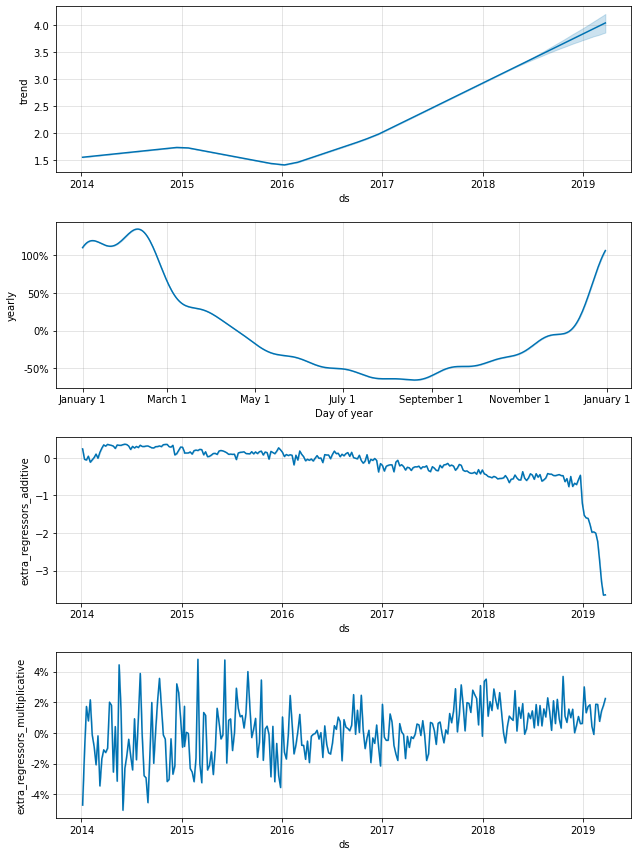

In [0]:
model = Prophet(weekly_seasonality=False, daily_seasonality=False,
                seasonality_mode='multiplicative')
model.add_regressor(name='pro_posts', mode="additive", standardize=True)
model.add_regressor(name='anti_posts', mode='additive', standardize=True)
model.add_regressor(name='pro_sent_neg', mode='multiplicative')
#model.add_regressor(name='pro_sent_neu', mode='multiplicative')
#model.add_regressor(name='pro_sent_pos', mode='multiplicative')
model.add_regressor(name='anti_sent_neg', mode='multiplicative')
#model.add_regressor(name='anti_sent_neu', mode='multiplicative')
#model.add_regressor(name='anti_sent_pos', mode='multiplicative')
model = model.fit(flu_train_regressors)

future['on_season'] = future['ds'].apply(is_flu_season)
future['off_season'] = ~future['ds'].apply(is_flu_season)

forecast = model.predict(future)
fig = model.plot_components(forecast)
plt.show()

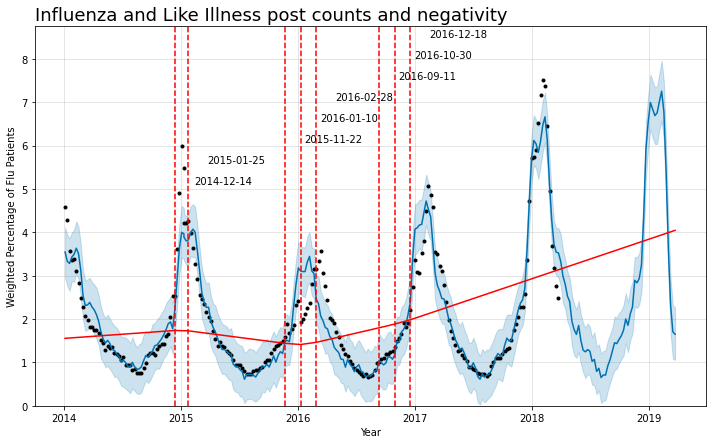

In [0]:
title = 'Influenza and Like Illness post counts and negativity'
plot_forecast(model, forecast, title)

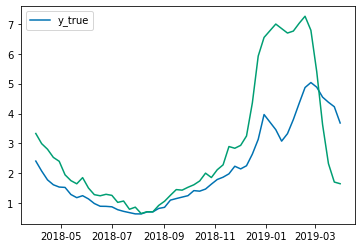

In [0]:
fig = plt.figure()
ax = plt.plot('ds', 'y_true', data=flu_test.rename({'y':'y_true'}, axis=1))
ax = plt.plot(flu_test['ds'], forecast[len(flu_train):]['yhat'])
plt.legend()
plt.show()

In [0]:
MSE_p = mean_squared_error(flu_test['y'], forecast[len(flu_train):]['yhat'])
print("Mean Square Error, no regressors:", MSE)
print("Mean Square Error, with flu season:", MSE_s)
print("Mean Square Error, with post counts and flu season:", MSE_r)
print("Mean Square Error, with posts, neg sent and flu season:", MSE_p)
MAE_p = mean_absolute_error(flu_test['y'], forecast[len(flu_train):]['yhat'])
print ('Mean Absolute Error:', MAE)
print("Mean Absolute Error, with flu season:", MAE_s)
print("Mean Absolute Error, with post counts and flu season:", MAE_r)
print("Mean Absolute Error, with posts, neg sent and flu season:", MAE_p)

Mean Square Error, no regressors: 2.943889299179837
Mean Square Error, with flu season: 3.199358331052075
Mean Square Error, with post counts and flu season: 2.1363902526089813
Mean Square Error, with posts, neg sent and flu season: 2.0386413676183635
Mean Absolute Error: 1.305606075581261
Mean Absolute Error, with flu season: 1.3643046937173828
Mean Absolute Error, with post counts and flu season: 1.011081574050602
Mean Absolute Error, with posts, neg sent and flu season: 0.9909135062471754


In [0]:
residuals = forecast[len(flu_train):].reset_index()['yhat'] - flu_test['y']

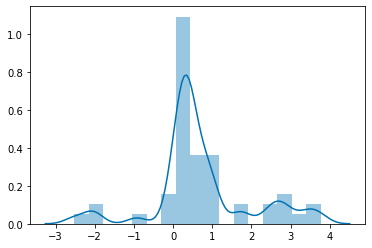

In [0]:
sns.distplot(residuals)
plt.show()

In [0]:
print(skew(residuals), residuals.mean(), residuals.median(), residuals.std())

0.3073631127973827 0.7012908385872827 0.40840063685454214 1.255851335504102


In [0]:
verif = pd.DataFrame([forecast[len(flu_train):].reset_index()['yhat'], flu_test.reset_index()['y']])
verif = verif.transpose()
verif

,yhat,y
0,3.331505,2.408020
1,2.991466,2.074830
2,2.804679,1.778980
3,2.530739,1.614870
4,2.400705,1.538500
5,1.947299,1.526120
6,1.753111,1.288470
7,1.647656,1.183440
8,1.853611,1.249190
9,1.505487,1.141310


In [0]:
corr = verif.loc[:,['y','yhat']].rolling(window=13, center=True).corr().iloc[0::2,1]

In [0]:
corr.index = corr.index.droplevel(1)

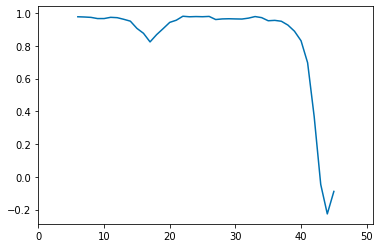

In [0]:
corr.plot()